In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [6]:
# X1.shape

In [7]:
# def blob_dataset(n_samples):
#     seed = 347
#     return make_blobs(n_samples=n_samples, n_features=2, centers=3)

In [8]:
# def clf_dataset_toy(n_samples):
#     seed = 347
# #     seed = 975
    
# #     plt.figure(figsize=(6, 6))
# #     plt.title("Multi-class, two informative features, one cluster", fontsize="small")
#     X1, Y1 = make_classification(n_samples=n_samples,
#         n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3, random_state=seed
#     )
#     return X1, Y1

In [8]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [13]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

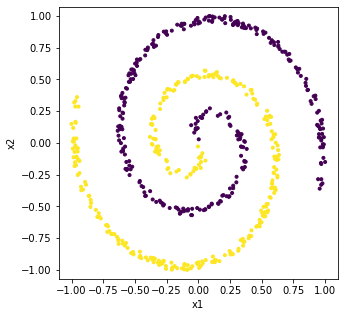

In [228]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

### Epsilon Softmax

In [229]:
xx, yy = xx.to(device), yy.to(device)

In [230]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [17]:
class ScaleShiftPositive(nn.Module):
    
    def __init__(self, input_dim, scale=1, shift=0):
        super().__init__()
        if scale is False:
            self.scaler = 1
        elif scale is None:
            self.scaler = nn.Parameter(torch.ones(1, input_dim)*0)
        else:
            self.scaler = nn.Parameter(torch.ones(1, input_dim)*np.log(scale))
            
        if shift is False:
            self.shifter = 0
        if shift is None:
            self.shifter = nn.Parameter(torch.ones(1, input_dim)*0)
        else:
            self.shifter =  nn.Parameter(torch.ones(1, input_dim)*shift)
        
    def forward(self, x):
        return x*torch.exp(self.scaler)+self.shifter

In [ ]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
        return self.softmax(torch.cat[self.sign*x, torch.ones(bs, 1)*self.epsilon])

In [18]:
# None is False

## Viz Residual

In [364]:
### Voroni diagram created for different scale ?? (Yes for different shift for sure.) 
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
#             dtnn.DistanceTransform_MinExp(2, h, bias=False),
#             SoftmaxTemp(10.0),
#             nn.BatchNorm1d(h),
#             nn.ELU(),
#             dtnn.OneActiv(h, mode="relu"),
            dtnn.OneActiv(h, mode="exp_1.6"), ## Has maximum at 1, max=1
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [365]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.68, Loss:0.6433584690093994
Epoch: 199, Acc:0.67, Loss:0.6112211346626282
Epoch: 299, Acc:0.73, Loss:0.5793733596801758
Epoch: 399, Acc:0.74, Loss:0.5414704084396362
Epoch: 499, Acc:0.74, Loss:0.49933290481567383
Epoch: 599, Acc:0.82, Loss:0.4504590928554535
Epoch: 699, Acc:0.91, Loss:0.39803364872932434
Epoch: 799, Acc:0.93, Loss:0.352557897567749
Epoch: 899, Acc:0.93, Loss:0.31243425607681274
Epoch: 999, Acc:0.93, Loss:0.27666038274765015


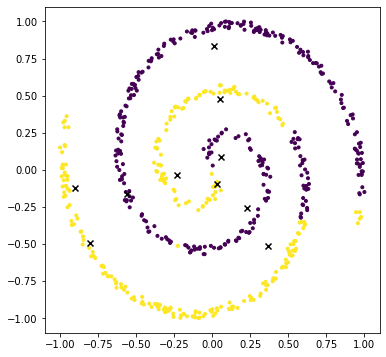

Epoch: 1099, Acc:0.94, Loss:0.2397044450044632
Epoch: 1199, Acc:0.95, Loss:0.20949237048625946
Epoch: 1299, Acc:0.95, Loss:0.1880035251379013
Epoch: 1399, Acc:1.00, Loss:0.10420456528663635
Epoch: 1499, Acc:1.00, Loss:0.06623387336730957
Epoch: 1599, Acc:1.00, Loss:0.04836765304207802
Epoch: 1699, Acc:1.00, Loss:0.03769656643271446
Epoch: 1799, Acc:1.00, Loss:0.030126800760626793
Epoch: 1899, Acc:1.00, Loss:0.024557022377848625
Epoch: 1999, Acc:1.00, Loss:0.020348044112324715


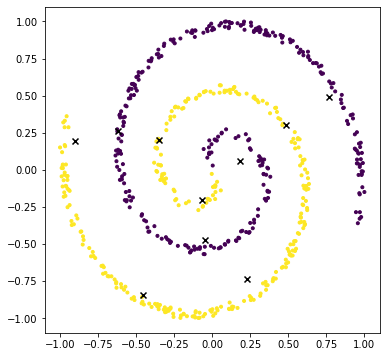

Epoch: 2099, Acc:1.00, Loss:0.017094938084483147
Epoch: 2199, Acc:1.00, Loss:0.014531584456562996
Epoch: 2299, Acc:1.00, Loss:0.01247766800224781
Epoch: 2399, Acc:1.00, Loss:0.010807814076542854
Epoch: 2499, Acc:1.00, Loss:0.009432743303477764
Epoch: 2599, Acc:1.00, Loss:0.008287599310278893
Epoch: 2699, Acc:1.00, Loss:0.007324368227273226
Epoch: 2799, Acc:1.00, Loss:0.006506927311420441
Epoch: 2899, Acc:1.00, Loss:0.005807672627270222
Epoch: 2999, Acc:1.00, Loss:0.005205220077186823


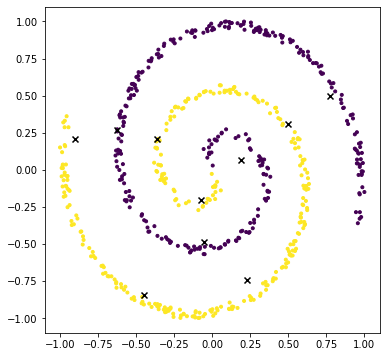

Epoch: 3099, Acc:1.00, Loss:0.004682823084294796
Epoch: 3199, Acc:1.00, Loss:0.004227178171277046
Epoch: 3299, Acc:1.00, Loss:0.0038276605773717165
Epoch: 3399, Acc:1.00, Loss:0.003475648583844304
Epoch: 3499, Acc:1.00, Loss:0.0031641218811273575
Epoch: 3599, Acc:1.00, Loss:0.0028872995171695948
Epoch: 3699, Acc:1.00, Loss:0.00264039752073586
Epoch: 3799, Acc:1.00, Loss:0.002419420052319765
Epoch: 3899, Acc:1.00, Loss:0.0022210178431123495
Epoch: 3999, Acc:1.00, Loss:0.002042358508333564


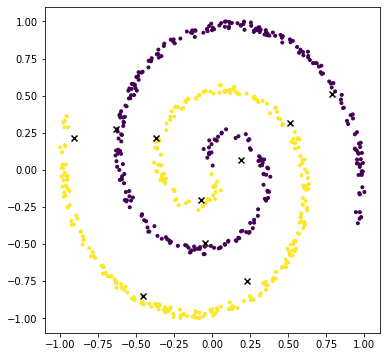

Epoch: 4099, Acc:1.00, Loss:0.001881044707261026
Epoch: 4199, Acc:1.00, Loss:0.0017350118141621351
Epoch: 4299, Acc:1.00, Loss:0.0016025006771087646
Epoch: 4399, Acc:1.00, Loss:0.0014820003416389227
Epoch: 4499, Acc:1.00, Loss:0.00137219054158777
Epoch: 4599, Acc:1.00, Loss:0.0012719315709546208
Epoch: 4699, Acc:1.00, Loss:0.0011802308727055788
Epoch: 4799, Acc:1.00, Loss:0.001096207182854414
Epoch: 4899, Acc:1.00, Loss:0.0010191001929342747
Epoch: 4999, Acc:1.00, Loss:0.0009482334135100245


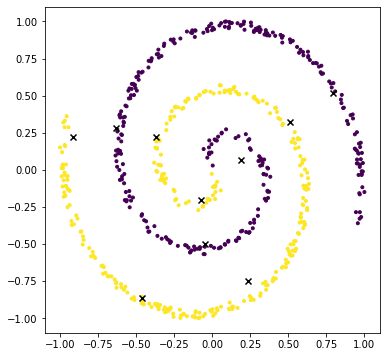

In [366]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [367]:
xx.device

device(type='cuda', index=0)

In [368]:
net.net[:-1]

Sequential(
  (0): DistanceTransform()
  (1): Sequential(
    (0): ScaleShift()
    (1): Softmax(dim=-1)
  )
  (2): OneActiv()
)

(array([  7.,   4.,   1.,   8.,  10.,  19.,  16.,  42.,  65., 428.]),
 array([0.34490255, 0.41041228, 0.47592202, 0.5414317 , 0.60694146,
        0.6724512 , 0.73796093, 0.8034707 , 0.8689804 , 0.93449014,
        0.9999999 ], dtype=float32),
 <BarContainer object of 10 artists>)

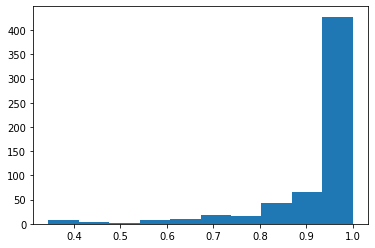

In [369]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

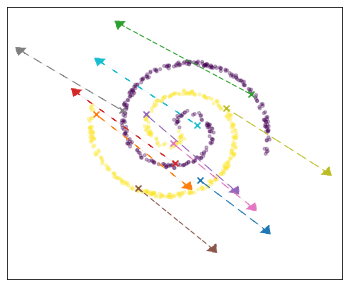

In [424]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

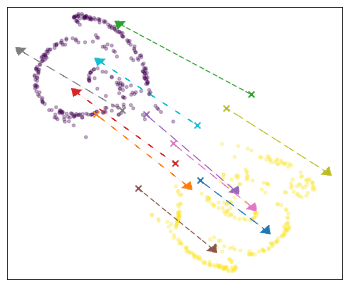

In [425]:
dev = (xx+net.net(xx)*0.5).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc='r', ec='r', linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()

In [354]:
net.net[-1].weight.data.cpu().t() + net.net[-1].bias.data.cpu()

tensor([[ 1.8237,  1.5703],
        [-2.1497, -0.5945],
        [ 0.5827,  0.8003],
        [ 1.3445,  0.5093],
        [-2.5632, -2.4481],
        [-2.7533, -1.8956],
        [-3.4070, -2.6481],
        [ 2.8209,  1.7779],
        [-1.6913, -1.3588],
        [ 0.7354,  0.1591]])